In [116]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [117]:
from lib import evaluate
from lib.serialize import iter_jl
import pandas as pd
import numpy as np

In [118]:
%reload_ext autoreload
%autoreload 2

In [119]:
dict_genres = {'pop': 1, 'country': 2, 'blues': 3, 'rock': 4, 'jazz': 5, "reggae": 6, "hip hop": 7}

In [120]:
df = pd.read_csv('tcc_ceds_music.csv')
df.shape

(28372, 31)

In [121]:
df['genre'] = df['genre'].apply(lambda x: dict_genres[x])

In [122]:
df["acousticness"] = np.cbrt(df["acousticness"]) # cube root transform

In [123]:
#df["instrumentalness"] = np.log(df["instrumentalness"] + 1)

In [124]:
df.shape

(28372, 31)

In [125]:
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,1,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.999330,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,1,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.984707,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,1,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.943674,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,1,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.437839,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,1,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.991902,0.000246,0.597073,0.394375,romantic,1.0


In [126]:
train, test = evaluate.date_split(df)

In [127]:
X_train, y_train = evaluate.x_y_split(train)
X_test, y_test = evaluate.x_y_split(test)

In [128]:
evaluate.to_json_lines(X_train,y_train,'train')
evaluate.to_json_lines(X_test,y_test,'test')

In [129]:
X_train, y_train = iter_jl('X_train.jl'), iter_jl('y_train.jl')

In [130]:
X_test, y_test = iter_jl('X_test.jl'), iter_jl('y_test.jl')

In [131]:
X_train = list(X_train)
y_train = list(y_train)
X_test = list(X_test)
y_test = list(y_test)

In [183]:
from lib.transformers import FeatureProjectionFromJson, TargetEncoder, PretrainedFastTextTransformer, TargetEncodeWithNumericalMean, TargetEncodeWithNumericalMaxOutlier, TargetEncodeWithNumericalMinOutlier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

fields = ['age','violence', 
                            'family/gospel','romantic','obscene','movement/places',
                           'light/visual perceptions','family/spiritual','sadness',
                           'danceability','loudness','acousticness','instrumentalness','valence','energy'] 

#saque algunos numericos: 'dating','like/girls','feelings', 'communication', 'world/life','night/time', 'music', 

features_pipe = make_union(make_pipeline(
        FeatureProjectionFromJson(fields)
    ,SimpleImputer()
    
),
                           #make_pipeline(FeatureProjectionFromJson(['topic']), OneHotEncoder()),
                          make_pipeline(TargetEncodeWithNumericalMean('topic', fields)),
                        
                           make_pipeline(TargetEncodeWithNumericalMean('artist_name', fields)),
                           
                           make_pipeline(PretrainedFastTextTransformer('lyrics_fasttext.bin','lyrics')),
                           
                          )

In [184]:
import lightgbm as lgb

In [185]:
rf_pipe = make_pipeline(
    features_pipe,
    lgb.LGBMClassifier(n_estimators =  100, random_state=42, class_weight = 'balanced')
)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureprojectionfromjson',
                                                                  FeatureProjectionFromJson(fields=['age',
                                                                                                    'violence',
                                                                                                    'family/gospel',
                                                                                                    'romantic',
                                                                                                    'obscene',
                                                                                                    'movement/places',
                                                                                                    'light/visual '
                                                                                                    'perceptions',
                                                                                                    'family/spiritual',
                                                                                                    'sadness',
                                                                                                    'danceability',
                                                                                                    'loudness',
                                                                                                    'acousticness',
                                                                                                    'instrumentalness',
                                                                                                    'vale...
                                                                                                                  'light/visual '
                                                                                                                  'perceptions',
                                                                                                                  'family/spiritual',
                                                                                                                  'sadness',
                                                                                                                  'danceability',
                                                                                                                  'loudness',
                                                                                                                  'acousticness',
                                                                                                                  'instrumentalness',
                                                                                                                  'valence',
                                                                                                                  'energy']))])),
                                                ('pipeline-4',
                                                 Pipeline(steps=[('pretrainedfasttexttransformer',
                                                                  PretrainedFastTextTransformer(field='lyrics',
                                                                                                fname='lyrics_fasttext.bin'))]))])),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', random_state=42))])

In [186]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics_multi(y_true, y_pred):
    dicc = {'f1': f1_score(y_true, y_pred, average = 'macro'),
      'precision': precision_score(y_true, y_pred, average = 'macro'),
      'acc': accuracy_score(y_true, y_pred),
      'recall': recall_score(y_true, y_pred, average = 'macro')}
    print(dicc)
    return(dicc)

In [187]:
get_metrics_multi(y_train,rf_pipe.predict(X_train))

{'f1': 0.9712182019382871, 'precision': 0.9685675118925833, 'acc': 0.9639504462911666, 'recall': 0.9741241381082838}


{'f1': 0.9712182019382871,
 'precision': 0.9685675118925833,
 'acc': 0.9639504462911666,
 'recall': 0.9741241381082838}

In [190]:
preds = rf_pipe.predict(X_test)

In [191]:
get_metrics_multi(y_test,preds)

{'f1': 0.6841180450146956, 'precision': 0.7040861473254728, 'acc': 0.6857142857142857, 'recall': 0.6789374884318268}


{'f1': 0.6841180450146956,
 'precision': 0.7040861473254728,
 'acc': 0.6857142857142857,
 'recall': 0.6789374884318268}

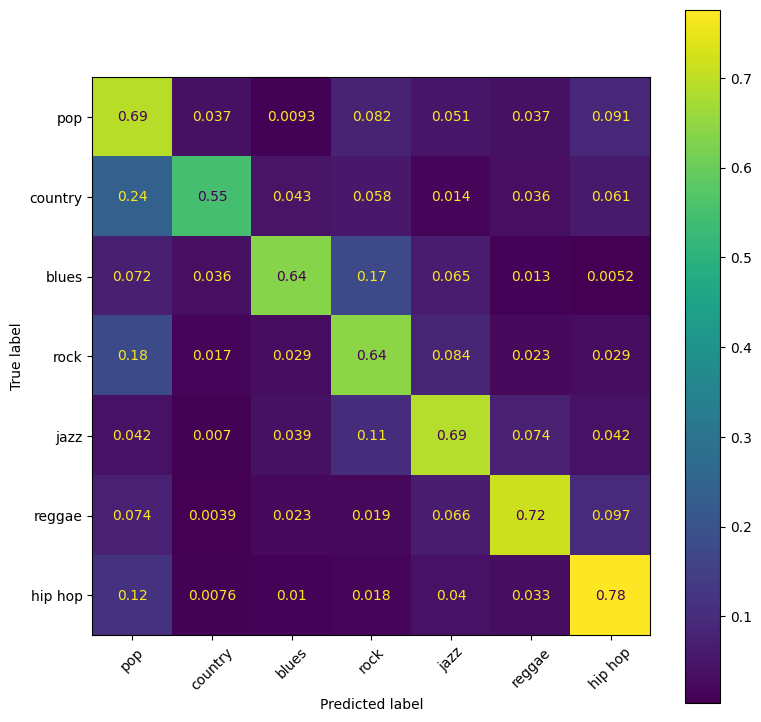

In [180]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pylab as plt
fig, ax  = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='true', ax=ax)
ax.xaxis.set_ticklabels(list(dict_genres.keys()))
ax.yaxis.set_ticklabels(list(dict_genres.keys()))
ax.xaxis.set_tick_params(rotation=45)

In [181]:
def get_confused_with(trueCategory,predictedCategory, preds, y_test):
    indexes = []
    for i,(pred,true) in enumerate(zip(preds,y_test)):
        if pred == predictedCategory and true == trueCategory:
            indexes.append(i)
    return indexes

In [182]:
test.iloc[get_confused_with(2,4, preds, y_test)]

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
12221,38290,high valley,dear life,2016,2,dear life know love mile road share hit miss t...,115,0.000521,0.206842,0.305570,...,0.049500,0.000521,0.533196,0.750994,0.261933,0.000000,0.437345,0.880877,world/life,0.057143
12243,38393,tyler farr,our town,2016,2,play cop robbers streets house game funny bunc...,65,0.001253,0.342352,0.138193,...,0.001253,0.048457,0.481209,0.844525,0.313196,0.000008,0.182811,0.772766,violence,0.057143
12266,38521,chase rice,whisper,2016,2,roll dial right minor chord steer night slide ...,130,0.061752,0.322896,0.000521,...,0.000521,0.000521,0.484458,0.788837,0.240176,0.000000,0.625927,0.891889,violence,0.057143
12276,38597,sturgill simpson,brace for impact (live a little),2016,2,life party break burden shoulder die live live...,44,0.031976,0.324461,0.306800,...,0.055081,0.001462,0.600347,0.738687,0.213472,0.316802,0.650660,0.706698,violence,0.057143
12295,38722,chris janson,redneck life,2017,2,grow batten board cabin dead gravel street pay...,108,0.000721,0.032375,0.518965,...,0.000721,0.000721,0.482292,0.801631,0.103958,0.000005,0.505359,0.961961,world/life,0.042857
12296,38724,the band steele,sit awhile,2017,2,wake favorite place studio hide space cold dar...,82,0.000702,0.066782,0.378398,...,0.000702,0.047301,0.497455,0.774787,0.481231,0.000000,0.381698,0.613602,world/life,0.042857
12309,38783,eli young band,never land,2017,2,word yeah wreck roll lips high good get bottle...,140,0.000424,0.000424,0.000424,...,0.338296,0.000424,0.538612,0.788632,0.189976,0.000005,0.505359,0.850846,sadness,0.042857
12323,38839,dirt rock empire,dirt road dollars,2017,2,lie reflect eye feel know know sleep night bre...,60,0.000940,0.086146,0.000940,...,0.000940,0.046646,0.576519,0.800477,0.236044,0.000000,0.433223,0.686677,night/time,0.042857
12335,38935,josh thompson,something's gonna get us all,2017,2,care feel care understand feel pity wealth los...,38,0.001698,0.001698,0.705636,...,0.074748,0.057605,0.474710,0.778812,0.353236,0.000000,0.546579,0.741734,world/life,0.042857
12353,39012,kelsea ballerini,unapologetically,2018,2,gonna fell fast gonna gonna late away yeah gon...,73,0.000810,0.000810,0.026014,...,0.328508,0.000810,0.514784,0.778248,0.260954,0.000000,0.516694,0.816811,sadness,0.028571


In [143]:
unseen_artists_test = test[~test['artist_name'].isin(train['artist_name'].unique())].copy()

In [144]:
X_unseen_artists_test, y_unseen_artists_test = evaluate.x_y_split(unseen_artists_test)
evaluate.to_json_lines(X_unseen_artists_test,y_unseen_artists_test,'unseen_artists_test')
X_unseen_artists_test, y_unseen_artists_test = list(iter_jl('X_unseen_artists_test.jl')), list(iter_jl('y_unseen_artists_test.jl'))

In [145]:
unseen_artists_preds = rf_pipe.predict(X_unseen_artists_test)

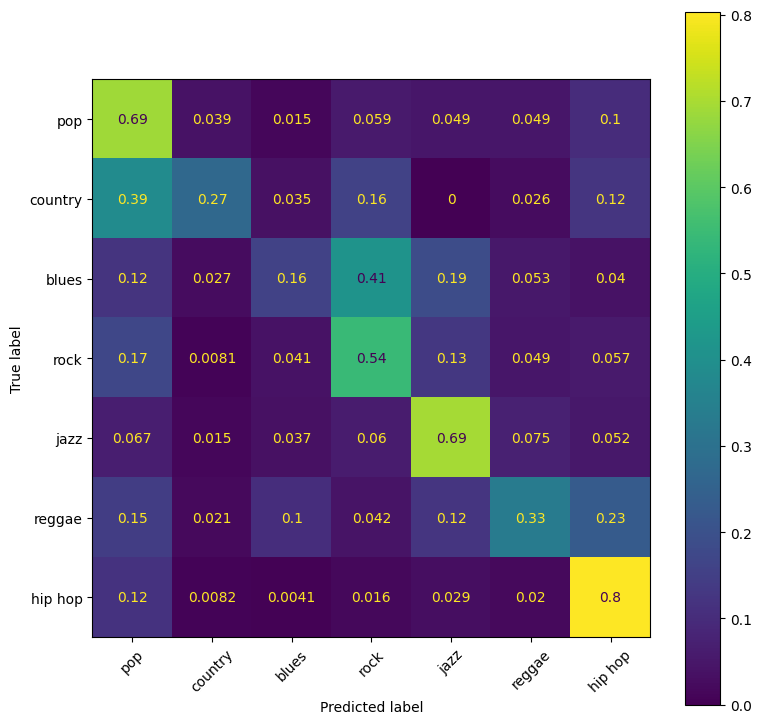

In [146]:
fig, ax  = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay.from_predictions(y_unseen_artists_test, unseen_artists_preds, normalize='true', ax=ax)
ax.xaxis.set_ticklabels(list(dict_genres.keys()))
ax.yaxis.set_ticklabels(list(dict_genres.keys()))
ax.xaxis.set_tick_params(rotation=45)

In [147]:
get_metrics_multi(y_unseen_artists_test,unseen_artists_preds)

{'f1': 0.49610317661331355, 'precision': 0.5295156633697644, 'acc': 0.5896076352067868, 'recall': 0.4992988603384068}


{'f1': 0.49610317661331355,
 'precision': 0.5295156633697644,
 'acc': 0.5896076352067868,
 'recall': 0.4992988603384068}

In [148]:
unseen_artists_test.iloc[get_confused_with(3,4, unseen_artists_preds, y_unseen_artists_test)] 

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
16761,53416,dorothy,wicked ones,2016,3,night faint heart faint heart faint heart nigh...,35,0.001949,0.260321,0.001949,...,0.363309,0.001949,0.568938,0.773966,0.328474,0.000000,0.584707,0.635624,sadness,0.057143
16769,53442,dorothy,raise hell,2016,3,gotta raise little hell young blood like river...,120,0.041756,0.402777,0.000474,...,0.000474,0.064296,0.525615,0.750019,0.282265,0.000000,0.713520,0.693684,violence,0.057143
16790,53527,goodbye june,good side,2017,3,time time want knife want decent life color ge...,120,0.000526,0.328806,0.000526,...,0.000526,0.083609,0.427055,0.803759,0.141453,0.002460,0.385820,0.919917,violence,0.042857
16818,53618,ron gallo,poor traits of the artist,2017,3,single ugly try good line idea scribble catch ...,35,0.001815,0.435279,0.001815,...,0.001815,0.069652,0.488790,0.760839,0.093111,0.000988,0.565128,0.856852,violence,0.042857
16823,53633,band of rascals,holler,2017,3,head turn burn head turn burn sparkle eye keep...,84,0.000721,0.186534,0.504055,...,0.000721,0.000721,0.332828,0.826065,0.302971,0.000000,0.370363,0.853849,world/life,0.042857
16843,53669,goodbye june,man of the moment,2017,3,climb mountain bleed greatness busy look yeah ...,39,0.074333,0.338557,0.067027,...,0.001754,0.063461,0.360988,0.809656,0.250729,0.000946,0.337387,0.905903,violence,0.042857
16850,53684,the record company,baby i'm broken,2017,3,break break break baby break tumble cause hear...,96,0.076467,0.000578,0.000578,...,0.459149,0.080185,0.427055,0.829628,0.053789,0.002460,0.596043,0.824819,sadness,0.042857
16864,53750,ron gallo,kill the medicine man,2017,3,want truth want truth stay close grind billboa...,39,0.001595,0.464211,0.051644,...,0.190415,0.001595,0.377234,0.754301,0.381722,0.000218,0.268343,0.823818,violence,0.042857
16870,53763,ron gallo,please yourself,2017,3,try everybody include wanna like tree spend li...,31,0.002024,0.002024,0.179197,...,0.305794,0.002024,0.382649,0.800323,0.031724,0.000000,0.793899,0.844840,sadness,0.042857
16894,53814,dorothy,black tar & nicotine,2018,3,raise million lie sell religion break home lea...,108,0.000578,0.421984,0.093747,...,0.238038,0.000578,0.427055,0.763582,0.625715,0.000007,0.369332,0.576563,violence,0.028571
